In [1]:
#     API Alpaca
#     Data cleanup
#     Consumer Discretionary Monte Carlo = XLY
#     Consumer Staples Monte Carlo = XLP
#     SP500 GROWTH Monte Carlo = SGX


In [2]:
#import libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os
import seaborn as sns
from dotenv import load_dotenv

%matplotlib inline

In [3]:
# Load .env enviroment variables

load_dotenv()

# Set Alpaca API key and secret
Api_key = os.getenv("Api_key")
Secret_key = os.getenv("Secret_key")

api = tradeapi.REST(Api_key, Secret_key, api_version='v2')
type(Api_key)


str

In [4]:
#Use alpha vantage to get historic quotes for XLY,XLP,IVW, and SPY. This goes back 20 years.

xly_df = api.alpha_vantage.historic_quotes('XLY', adjusted=True, output_format='pandas')
xly_df.head()

xlp_df = api.alpha_vantage.historic_quotes('XLP', adjusted=True, output_format='pandas')
#xlp_df.tail()

ivw_df = api.alpha_vantage.historic_quotes('IVW', adjusted=True, output_format='pandas')
#ivw_df.head()

spy_df = api.alpha_vantage.historic_quotes('SPY', adjusted=True, output_format='pandas')


In [5]:
spy_df.head()


,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-05-01,285.31,290.6572,281.52,282.79,282.79,125045778.0,0.0,1.0
2020-04-30,291.71,293.3239,288.59,290.48,290.48,121537052.0,0.0,1.0
2020-04-29,291.53,294.8800,290.41,293.21,293.21,118066585.0,0.0,1.0
2020-04-28,291.02,291.4000,285.40,285.73,285.73,104797847.0,0.0,1.0
2020-04-27,285.12,288.2700,284.62,287.05,287.05,77516422.0,0.0,1.0


In [6]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xly_df = xly_df['5. adjusted close']
xly_df.head()

xlp_df = xlp_df['5. adjusted close']
xlp_df.head()

ivw_df = ivw_df['5. adjusted close']
ivw_df.head()

spy_df = spy_df['5. adjusted close']
spy_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([xly_df, xlp_df, ivw_df, spy_df], axis = "columns", join = "inner")
concat_df.head()
    

,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close
date,,,,
2020-05-01,112.24,57.62,183.70,282.79
2020-04-30,116.60,58.26,188.57,290.48
2020-04-29,117.33,58.96,188.89,293.21
2020-04-28,114.80,59.21,183.09,285.73
2020-04-27,114.35,58.88,185.34,287.05


In [7]:
#print column names
print(concat_df.columns)


Index(['5. adjusted close', '5. adjusted close', '5. adjusted close',
       '5. adjusted close'],
      dtype='object')


In [8]:
#Change column names to avoid confusion
columns = ['XLY close', 'XLP close', 'IVW close', 'SPY close']
concat_df.columns = columns
concat_df.head()


,XLY close,XLP close,IVW close,SPY close
date,,,,
2020-05-01,112.24,57.62,183.70,282.79
2020-04-30,116.60,58.26,188.57,290.48
2020-04-29,117.33,58.96,188.89,293.21
2020-04-28,114.80,59.21,183.09,285.73
2020-04-27,114.35,58.88,185.34,287.05


In [9]:
#Sort earliest to latest so that .pct_change() function works right.

concat_df.sort_index(inplace=True, ascending=True)
concat_df.head()

,XLY close,XLP close,IVW close,SPY close
date,,,,
2000-05-26,20.4125,15.2972,61.6055,94.5076
2000-05-30,20.5678,15.2091,64.1619,97.5894
2000-05-31,21.0571,15.0643,64.1619,97.8034
2000-06-01,21.2125,15.1021,64.9608,99.5155
2000-06-02,21.7950,14.5798,67.0988,101.2489


In [10]:
returns_df = concat_df.pct_change()
returns_df

,XLY close,XLP close,IVW close,SPY close
date,,,,
2000-05-26,NaN,NaN,NaN,NaN
2000-05-30,0.007608,-0.005759,0.041496,0.032609
2000-05-31,0.023790,-0.009521,0.000000,0.002193
2000-06-01,0.007380,0.002509,0.012451,0.017506
2000-06-02,0.027460,-0.034585,0.032912,0.017418
...,...,...,...,...
2020-04-27,0.018708,0.002896,0.010027,0.014418
2020-04-28,0.003935,0.005605,-0.012140,-0.004599
2020-04-29,0.022038,-0.004222,0.031678,0.026179


In [11]:
#check for nulls

returns_df.isnull().sum()

XLY close    1
XLP close    1
IVW close    1
SPY close    1
dtype: int64

In [12]:
# Drop nulls
returns_df.dropna(inplace=True)

#count nulls again
returns_df.isnull().sum()

XLY close    0
XLP close    0
IVW close    0
SPY close    0
dtype: int64

In [13]:
# Checking for duplicate rows
returns_df.duplicated()

date
2000-05-30    False
2000-05-31    False
2000-06-01    False
2000-06-02    False
2000-06-05    False
              ...  
2020-04-27    False
2020-04-28    False
2020-04-29    False
2020-04-30    False
2020-05-01    False
Length: 5013, dtype: bool

In [14]:
# drop duplicates
returns_df.drop_duplicates(inplace=True)
returns_df.head()

,XLY close,XLP close,IVW close,SPY close
date,,,,
2000-05-30,0.007608,-0.005759,0.041496,0.032609
2000-05-31,0.023790,-0.009521,0.000000,0.002193
2000-06-01,0.007380,0.002509,0.012451,0.017506
2000-06-02,0.027460,-0.034585,0.032912,0.017418
2000-06-05,-0.005345,-0.001296,-0.004990,-0.004861


In [15]:
# drop close columns to create dataframe for daily returns
returns_df.rename(columns={'XLY close': 'XLY return',
                           'XLP close': 'XLP return',
                           'IVW close': 'IVW return',
                           'SPY close': 'SP500 return'},
                  inplace=True)
returns_df.head()

,XLY return,XLP return,IVW return,SP500 return
date,,,,
2000-05-30,0.007608,-0.005759,0.041496,0.032609
2000-05-31,0.023790,-0.009521,0.000000,0.002193
2000-06-01,0.007380,0.002509,0.012451,0.017506
2000-06-02,0.027460,-0.034585,0.032912,0.017418
2000-06-05,-0.005345,-0.001296,-0.004990,-0.004861


In [19]:

# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_xly = (1 + returns_df['XLY return']).cumprod()
cumulative_returns_xlp = (1 + returns_df['XLP return']).cumprod()
cumulative_returns_ivw = (1 + returns_df['IVW return']).cumprod()
cumulative_returns_spy = (1 + returns_df['SP500 return']).cumprod()


In [20]:
cumulative_returns_xly.head()

date
2000-05-30    1.007608
2000-05-31    1.031579
2000-06-01    1.039192
2000-06-02    1.067728
2000-06-05    1.062021
Name: XLY return, dtype: float64

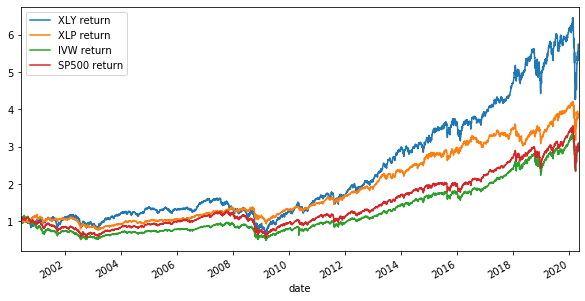

In [21]:
#plot cumulative returns

cumulative_returns_xly.plot(figsize=(10,5), legend=True)
cumulative_returns_xlp.plot(figsize=(10,5), legend=True)
cumulative_returns_ivw.plot(figsize=(10,5), legend=True)
cumulative_returns_spy.plot(figsize=(10,5), legend=True)

In [22]:
#calculate value of standard deviation of daily returns
#use the std function to calculate the standard deviation of daily returns for XLY, XLP, & SGX

std_xly_daily_returns = returns_df['XLY return'].std()
print (f'Consumer Discretionary standard deviation is {std_xly_daily_returns}')

std_xlp_daily_returns = returns_df['XLP return'].std()
print (f'Consumer Staples standard deviation is {std_xlp_daily_returns}')

std_ivw_daily_returns = returns_df['IVW return'].std()
print (f'S&P 500 Growth standard deviation is {std_ivw_daily_returns}')

std_spy_daily_returns = returns_df['SP500 return'].std()
print (f'S&P 500 standard deviation is {std_spy_daily_returns})')


Consumer Discretionary standard deviation is 0.014070234125883442
Consumer Staples standard deviation is 0.009523077075917048
S&P 500 Growth standard deviation is 0.013299957044347598
S&P 500 standard deviation is 0.012425981029282685)


In [23]:
# Calculate the annualized standard deviation (252 trading days) for each sector
annual_xly_std = std_xly_daily_returns * np.sqrt(252)
annual_xly_std

annual_xlp_std = std_xlp_daily_returns * np.sqrt(252)
annual_xlp_std

annual_ivw_std = std_ivw_daily_returns * np.sqrt(252)
annual_ivw_std

annual_spy_std = std_spy_daily_returns * np.sqrt(252)
annual_spy_std

0.19725633359693037

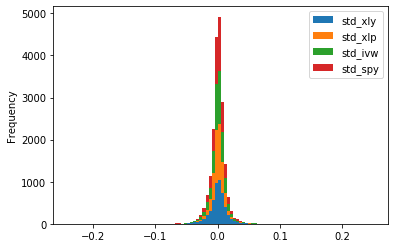

In [24]:
#Plot

sectors_std = pd.DataFrame({
    "std_xly": returns_df['XLY return'],
    "std_xlp": returns_df['XLP return'],
    "std_ivw": returns_df['IVW return'],
    "std_spy": returns_df['SP500 return']
})

sectors_std.plot.hist(stacked=True, bins=100)

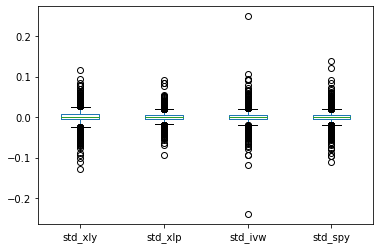

In [25]:
sectors_std.plot.box()


In [26]:
# Calculate Sharpe Ratios for the sectors

XLY_sharpe = (returns_df['XLY return'].mean() * 252) / (returns_df['XLY return'].std() * np.sqrt(252))

XLP_sharpe = (returns_df['XLP return'].mean() * 252) / (returns_df['XLP return'].std() * np.sqrt(252))

IVW_sharpe = (returns_df['IVW return'].mean() * 252) / (returns_df['IVW return'].std() * np.sqrt(252))

SPY_sharpe = (returns_df['SP500 return'].mean() * 252) / (returns_df['SP500 return'].std() * np.sqrt(252))

print(f" XLY: {XLY_sharpe}, XLP: {XLP_sharpe}, IVW:{IVW_sharpe}, SPY:{SPY_sharpe}")




 XLY: 0.4955995473665896, XLP: 0.516631849698764, IVW:0.36610999593867377, SPY:0.37802120016801444


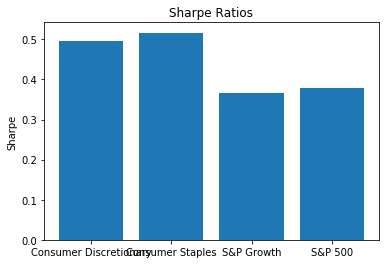

In [29]:
#Plot the sharpe ratios

objects = ('Consumer Discretionary', 'Consumer Staples', 'S&P Growth', 'S&P 500')
y_pos = np.arange(len(objects))
sharpe = [XLY_sharpe,XLP_sharpe,IVW_sharpe, SPY_sharpe]

plt.bar(y_pos, sharpe, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Sharpe')
plt.title('Sharpe Ratios')

plt.show()

In [30]:
# Drop nulls on Returns
returns_df.dropna(inplace=True)

#count nulls 
returns_df.isnull().sum()

XLY return      0
XLP return      0
IVW return      0
SP500 return    0
dtype: int64

In [31]:
#Check correlation

sector_correlation = returns_df.corr()
sector_correlation

,XLY return,XLP return,IVW return,SP500 return
XLY return,1.000000,0.632985,0.796894,0.864058
XLP return,0.632985,1.000000,0.659355,0.716253
IVW return,0.796894,0.659355,1.000000,0.896600
SP500 return,0.864058,0.716253,0.896600,1.000000


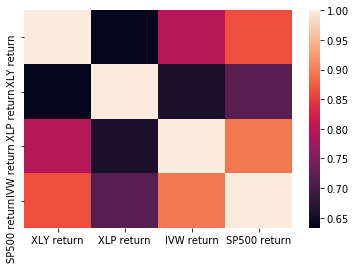

In [32]:
# Heapmap to visualize sector correlation
sns.heatmap(sector_correlation)

In [33]:
#BETA CALCULATION CONSUMER DISCRETIONARY Sector and S&P 500

# Calculate covariance of XLY vs. S&P 500
xly_covariance = returns_df['XLY return'].cov(returns_df['SP500 return'])
xly_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500 return'].var()
variance

# Calculate beta of Consumer Discretionary Sector
xly_beta = xly_covariance / variance
xly_beta

0.9783929032648041

In [34]:
#BETA CALCULATION CONSUMER STAPLES Sector and S&P 500

# Calculate covariance of XLP vs. S&P 500
xlp_covariance = returns_df['XLP return'].cov(returns_df['SP500 return'])
xlp_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500 return'].var()
variance

# Calculate beta of Consumer Staples Sector
xlp_beta = xlp_covariance / variance
xlp_beta

0.548925338084802

In [35]:
#BETA CALCULATION SP Growth Sector and S&P 500

# Calculate covariance of IVW vs. S&P 500
ivw_covariance = returns_df['IVW return'].cov(returns_df['SP500 return'])
ivw_covariance

# Calculate variance of S&P 500 returns
variance = returns_df['SP500 return'].var()
variance

# Calculate beta of SP Growth Sector
ivw_beta = ivw_covariance / variance
ivw_beta

0.959662288956733

A 10,000 investment in the Consumer Discretionary Sector would have increased to 54985.915492957756


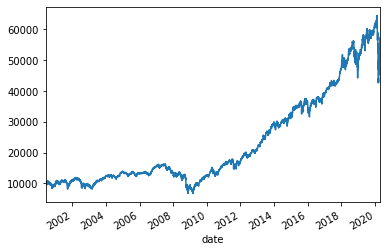

In [42]:
# Plot the monetary returns of Consumer Discretionary Sector 
initial_investment = 10000
cumulative_profit_xly = initial_investment * cumulative_returns_xly
print(f'A 10,000 investment in the Consumer Discretionary Sector would have increased to {cumulative_profit_xly[-1]}')
cumulative_profit_xly.plot()

A 10,000 investment in the Consumer Staples Sector would have increased to 37667.02403054126


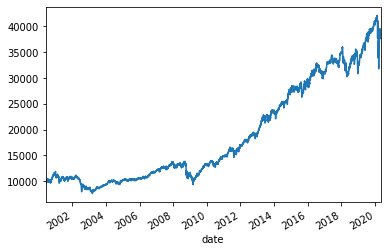

In [45]:
# Plot the monetary returns of Consumer Staples Sector 
initial_investment = 10000
cumulative_profit_xlp = initial_investment * cumulative_returns_xlp
print(f'A 10,000 investment in the Consumer Staples Sector would have increased to {cumulative_profit_xlp[-1]}')
cumulative_profit_xlp.plot()

A 10,000 investment in the SP Growth Sector would have increased to 29818.766181590974


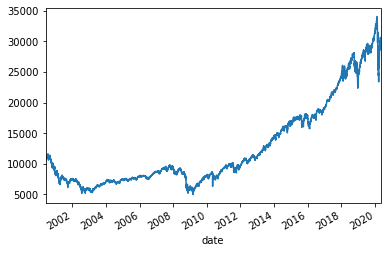

In [47]:
# Plot the monetary returns of SP Growth Sector 
initial_investment = 10000
cumulative_profit_ivw = initial_investment * cumulative_returns_ivw
print(f'A 10,000 investment in the SP Growth Sector would have increased to {cumulative_profit_ivw[-1]}')
cumulative_profit_ivw.plot()

In [48]:
#START MONTE CARLO ANALYSIS (XLY: Consumer Discretionary)

#check concat_df
returns_df.head()

,XLY return,XLP return,IVW return,SP500 return
date,,,,
2000-05-30,0.007608,-0.005759,0.041496,0.032609
2000-05-31,0.023790,-0.009521,0.000000,0.002193
2000-06-01,0.007380,0.002509,0.012451,0.017506
2000-06-02,0.027460,-0.034585,0.032912,0.017418
2000-06-05,-0.005345,-0.001296,-0.004990,-0.004861


In [50]:
#calculate average of daily returns
avg_xly_daily_returns = returns_df['XLY return'].mean()
avg_xly_daily_returns

avg_xlp_daily_returns = returns_df['XLP return'].mean()
avg_xlp_daily_returns

avg_ivw_daily_returns = returns_df['IVW return'].mean()
avg_ivw_daily_returns

avg_spy_daily_returns = returns_df['SP500 return'].mean()
avg_spy_daily_returns


0.00029590109510735656

In [51]:
#Check datatypes

returns_df.dtypes


XLY return      float64
XLP return      float64
IVW return      float64
SP500 return    float64
dtype: object

In [98]:
#check counts
returns_df.count()

XLY return      5013
XLP return      5013
IVW return      5013
SP500 return    5013
dtype: int64

In [99]:
#use describe to explore data
returns_df.describe()

,XLY return,XLP return,IVW return,SP500 return
count,5013.000000,5013.000000,5013.000000,5013.000000
mean,0.000439,0.000310,0.000307,0.000296
std,0.014070,0.009523,0.013300,0.012426
min,-0.126686,-0.093956,-0.238912,-0.109423
25%,-0.005737,-0.004184,-0.004663,-0.004512
50%,0.000820,0.000442,0.000694,0.000655
75%,0.007112,0.005134,0.005807,0.005766
max,0.116572,0.091354,0.248785,0.139609


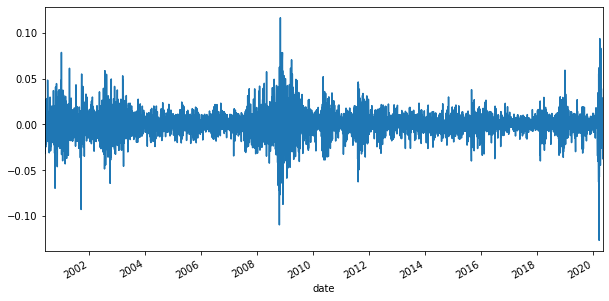

In [100]:
#plot daily returns of XLY

returns_df['XLY return'].plot(figsize=(10,5))

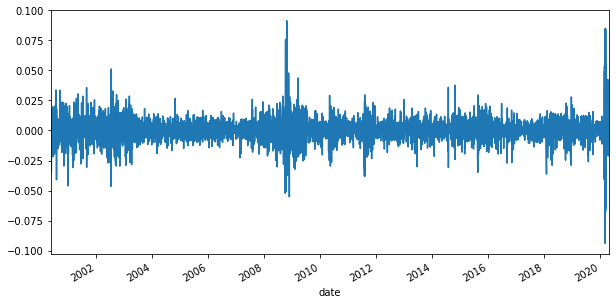

In [101]:
#plot daily returns of XLP

returns_df['XLP return'].plot(figsize=(10,5))

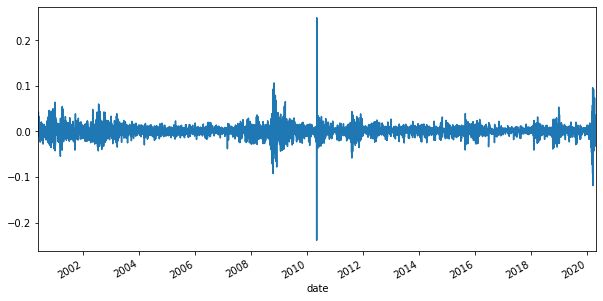

In [102]:
#plot daily returns of IVW

returns_df['IVW return'].plot(figsize=(10,5))

In [104]:
#need to check on dividend

In [52]:
#START MONTE CARLO ANALYSIS (XLY)
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLY from DataFrame

num_trading_days = 30
xly_last_price = xly_df[1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLY_df = pd.DataFrame()


In [53]:
## Run the simulation `1000` times for XLY
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLY
    simulated_XLY_prices = [xly_last_price]
    simulated_XLY_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLY_prices[-1] * (1 + np.random.normal(avg_xly_daily_returns, std_xly_daily_returns))
        # Append the simulated price to the list
        simulated_XLY_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLY_df[f"Simulation {n+1}"] = pd.Series(simulated_XLY_prices)

simulated_prices_XLY_df.head()




,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,...,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000,116.600000
1,113.892682,116.863110,115.148648,118.394236,116.915220,113.624150,118.633389,116.759012,117.670199,117.087018,...,116.869362,117.118310,114.499913,116.410673,118.750672,117.794552,116.236366,114.244080,117.753031,116.119587
2,114.981331,116.993145,114.135489,117.188621,117.339828,111.411818,120.127759,119.577590,114.000060,111.552071,...,114.737744,115.889471,114.376449,117.168093,119.266915,118.916185,115.518595,115.350931,118.443592,114.053530
3,115.399366,117.651015,113.132387,115.654908,118.856258,112.015074,117.915039,118.812238,114.831409,110.204080,...,118.081126,117.578016,114.312166,116.517571,117.593655,117.235690,115.119911,116.450387,117.388171,114.490706
4,117.704727,116.253537,113.999203,116.494901,119.327866,107.771387,119.544839,118.340050,115.112344,110.506772,...,117.374982,118.486805,114.696269,115.539927,117.468358,116.268284,113.979064,116.601956,119.257836,118.955206


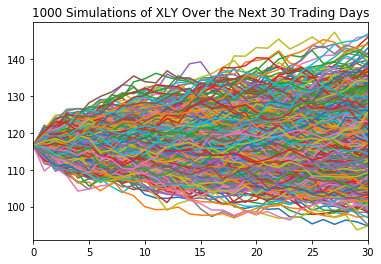

In [54]:
#plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of XLY Over the Next 30 Trading Days"
simulated_prices_XLY_df.plot(legend=None, title=plot_title)


In [55]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_XLY = simulated_prices_XLY_df.iloc[-1, :]
simulated_ending_prices_XLY.head()


Simulation 1    118.306409
Simulation 2    136.570027
Simulation 3    101.874334
Simulation 4    103.589403
Simulation 5    126.268689
Name: 30, dtype: float64

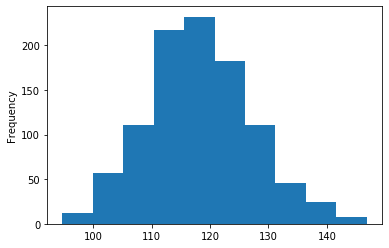

In [56]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_XLY.plot(kind='hist')


In [57]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_XLY.quantile(q=[0.025, 0.975])
confidence_interval


0.025    101.870540
0.975    136.967406
Name: 30, dtype: float64

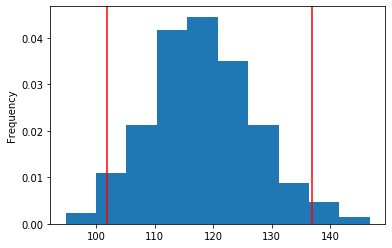

In [58]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_XLY.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [60]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - xly_last_price) / xly_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - xly_last_price) / xly_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in Consumer Discretionary"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")


There is a 95% chance that an initial investment of $10,000 in Consumer Discretionary over the next 30 trading days will end within in the range of $8736.75 and $11746.78


In [61]:
#START MONTE CARLO ANALYSIS Consumer Staples

#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLP from DataFrame

num_trading_days = 30
xlp_last_price = xlp_df[1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLP_df = pd.DataFrame()


In [62]:
## Run the simulation `1000` times for XLP: Consumer Staples
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLP
    simulated_XLP_prices = [xlp_last_price]
    simulated_XLP_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLP_prices[-1] * (1 + np.random.normal(avg_xlp_daily_returns, std_xlp_daily_returns))
        # Append the simulated price to the list
        simulated_XLP_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLP_df[f"Simulation {n+1}"] = pd.Series(simulated_XLP_prices)

simulated_prices_XLP_df.head()


,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,...,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000,58.260000
1,58.347756,58.512858,58.186712,57.202004,58.349496,58.245908,58.735477,57.992100,58.190514,58.713611,...,57.449191,58.738296,58.653740,58.178440,57.389189,58.143469,58.687128,58.779483,58.428282,57.732232
2,60.013561,59.110390,57.468715,57.904268,58.515807,58.974491,59.244145,57.979729,58.665105,59.482023,...,57.681717,58.918096,58.936342,58.210410,57.341178,58.531961,59.528669,58.813123,59.541629,57.928048
3,60.000555,58.672880,57.148434,57.766549,58.569033,58.484988,59.989512,57.664031,58.714146,58.971854,...,58.351974,59.845996,59.171379,58.397586,57.604856,59.090240,59.898192,58.040483,59.789752,57.794198
4,60.510090,58.418877,57.119084,57.647182,59.513399,58.381590,59.686409,57.587137,58.784892,59.403912,...,58.353816,59.747124,59.495936,58.674569,59.430371,58.231847,58.928176,58.178907,60.060566,57.519838


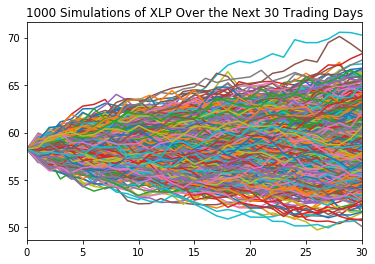

In [63]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of XLP Over the Next 30 Trading Days"
simulated_prices_XLP_df.plot(legend=None, title=plot_title)


In [66]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_XLP = simulated_prices_XLP_df.iloc[-1, :]
simulated_ending_prices_XLP.head()


Simulation 1    61.054903
Simulation 2    55.018375
Simulation 3    56.273885
Simulation 4    57.583006
Simulation 5    54.502450
Name: 30, dtype: float64

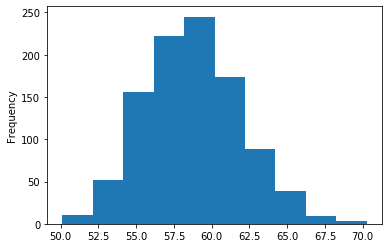

In [67]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_XLP.plot(kind='hist')


In [68]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_XLP.quantile(q=[0.025, 0.975])
confidence_interval

0.025    52.903236
0.975    65.470701
Name: 30, dtype: float64

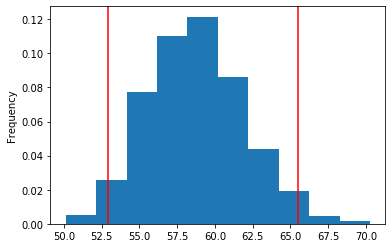

In [71]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_XLP.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')


In [72]:

# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - xlp_last_price) / xlp_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - xlp_last_price) / xlp_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the Consumer Staples sector"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in the Consumer Staples sector over the next 30 trading days will end within in the range of $9080.54 and $11237.68


In [73]:
#Set up Monte Carlo Simulation for SP Growth: IVW

#Set number of simulations

num_simulations = 1000

# Set number of trading days and get last closing price of IVW from DataFrame

num_trading_days = 30
ivw_last_price = ivw_df[1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_ivw_df = pd.DataFrame()

In [74]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of IVW
    simulated_ivw_prices = [ivw_last_price]
    simulated_ivw_prices

    # Simulate the returns for 30 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price_ivw = simulated_ivw_prices[-1] * (1 + np.random.normal(avg_ivw_daily_returns, std_ivw_daily_returns))
        # Append the simulated price to the list
        simulated_ivw_prices.append(simulated_price_ivw)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_ivw_df[f"Simulation {n+1}"] = pd.Series(simulated_ivw_prices)

simulated_prices_ivw_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,...,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000,188.570000
1,189.883737,188.059722,187.803427,188.744250,186.068415,187.427868,187.829265,186.947405,185.575374,190.236175,...,185.595774,187.752093,187.384059,190.303496,185.094781,187.728944,186.848116,188.800472,188.209182,191.572155
2,187.206879,183.337382,184.573512,189.064625,186.353917,188.844058,189.641367,188.860004,185.561870,191.515057,...,186.030166,189.856423,191.430674,189.309241,183.644393,187.673821,184.465345,192.178526,191.490368,191.542167
3,186.902158,189.199699,184.484303,187.888856,181.954744,188.450118,193.921147,188.176163,181.109186,191.052654,...,189.471253,183.127517,191.162158,191.142779,187.502639,182.666695,184.428321,192.497470,191.206596,191.578823
4,189.619334,189.308095,186.458316,189.873738,182.468095,190.328873,195.475137,185.372867,180.447050,193.834669,...,186.962312,177.295177,191.448981,189.847209,184.707591,184.485776,184.110851,191.179857,192.293299,192.647924


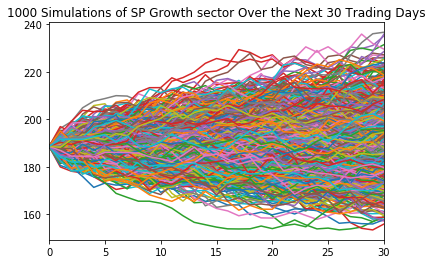

In [75]:
#Plot 1000 simulations of 30 trading days
plot_title = f"{n+1} Simulations of SP Growth sector Over the Next 30 Trading Days"
simulated_prices_ivw_df.plot(legend=None, title=plot_title)


In [76]:
# Select the last row (price of each simulation on the 30th trading day)
simulated_ending_prices_ivw = simulated_prices_ivw_df.iloc[-1, :]
simulated_ending_prices_ivw.head()


Simulation 1    176.296995
Simulation 2    173.971892
Simulation 3    201.946624
Simulation 4    192.392850
Simulation 5    174.685517
Name: 30, dtype: float64

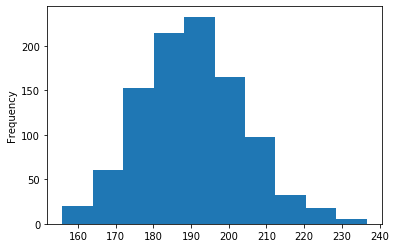

In [78]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_ivw.plot(kind='hist')


In [79]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_ivw.quantile(q=[0.025, 0.975])
confidence_interval

0.025    164.921739
0.975    219.468390
Name: 30, dtype: float64

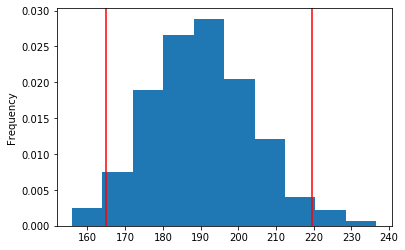

In [80]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_ivw.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [81]:

# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - ivw_last_price) / ivw_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - ivw_last_price) / ivw_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the S&P Growth sector"
      f" over the next 30 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")


There is a 95% chance that an initial investment of $10,000 in the S&P Growth sector over the next 30 trading days will end within in the range of $8745.92 and $11638.56


In [82]:
# BEGIN USING PYPORTFOLIO OPT LIBRARY - Note I used all eleven sectors below
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import Plotting
from pypfopt import CLA
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage



In [83]:
#Use alpha vantage to get historic quotes for all S&P sectors. This goes back 20 years.

# Can only do 5 calls a minute or you will get error. Might have to wait a minute after
#running this cell. 

xlb_df = api.alpha_vantage.historic_quotes('XLB', adjusted=True, output_format='pandas')
#xlb_df.head()

xlk_df = api.alpha_vantage.historic_quotes('XLK', adjusted=True, output_format='pandas')
# xlk_df.tail()

rwr_df = api.alpha_vantage.historic_quotes('RWR', adjusted=True, output_format='pandas')
#rwr_df.head()

xli_df = api.alpha_vantage.historic_quotes('XLI', adjusted=True, output_format='pandas')
#rwr_df.head()

xly_df = api.alpha_vantage.historic_quotes('XLY', adjusted=True, output_format='pandas')
#xly_df.head()

In [84]:
#Might have to wait a minute before running this cell

xlp_df = api.alpha_vantage.historic_quotes('XLP', adjusted=True, output_format='pandas')
#xlp_df.head()

xle_df = api.alpha_vantage.historic_quotes('XLE', adjusted=True, output_format='pandas')
#xle_df.head()

xlf_df = api.alpha_vantage.historic_quotes('XLF', adjusted=True, output_format='pandas')
#xlf_df.head()

xlu_df = api.alpha_vantage.historic_quotes('XLU', adjusted=True, output_format='pandas')
#xlu_df.head()

xlv_df = api.alpha_vantage.historic_quotes('XLV', adjusted=True, output_format='pandas')
#xlv_df.head()

In [85]:
#Might have to wait a minute before running this cell

iyt_df = api.alpha_vantage.historic_quotes('IYT', adjusted=True, output_format='pandas')
#iyt_df.head()

In [86]:
xlu_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-05-01,56.59,56.630,55.5600,55.88,55.88,13458584.0,0.0,1.0
2020-04-30,58.19,58.280,56.7300,57.26,57.26,19366858.0,0.0,1.0
2020-04-29,60.11,60.140,58.3700,58.61,58.61,11782714.0,0.0,1.0
2020-04-28,59.76,60.400,58.8778,59.15,59.15,14321700.0,0.0,1.0
2020-04-27,58.66,59.355,58.6000,58.93,58.93,12739948.0,0.0,1.0


In [87]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xlb_df = xlb_df['5. adjusted close']
xlb_df.head()

xlk_df = xlk_df['5. adjusted close']
xlk_df.head()

rwr_df = rwr_df['5. adjusted close']
rwr_df.head()

xli_df = xli_df['5. adjusted close']
xli_df.head()

xly_df = xly_df['5. adjusted close']
xly_df.head()

xlp_df = xlp_df['5. adjusted close']
xlp_df.head()

xle_df = xle_df['5. adjusted close']
xle_df.head()

xlf_df = xlf_df['5. adjusted close']
xlf_df.head()

xlu_df = xlu_df['5. adjusted close']
xlu_df.head()

xlv_df = xlv_df['5. adjusted close']
xlv_df.head()

iyt_df = iyt_df['5. adjusted close']
iyt_df.head()


#Use concat to put the data in one dataframe
concat_df = pd.concat([xlb_df, xlk_df, rwr_df, xli_df, xly_df, xlp_df, xle_df, xlf_df, xlu_df, xlv_df, iyt_df], 
                      axis = "columns", join = "inner")
concat_df.head()


,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close
date,,,,,,,,,,,
2020-05-01,50.79,88.90,75.11,62.27,112.24,57.62,35.85,22.06,55.88,97.83,144.775
2020-04-30,51.88,91.41,77.87,64.21,116.60,58.26,38.00,22.79,57.26,99.73,149.920
2020-04-29,53.47,91.82,79.10,65.51,117.33,58.96,38.86,23.38,58.61,100.19,154.400
2020-04-28,52.14,88.20,77.38,64.28,114.80,59.21,36.18,22.72,59.15,99.53,150.270
2020-04-27,51.19,89.39,76.08,63.10,114.35,58.88,35.37,22.48,58.93,101.58,148.900


In [88]:

#Change column names to avoid confusion
columns = ['XLB', 'XLK', 'RWR', 'XLI', 'XLY', 'XLP', 'XLE', 'XLF', 'XLU', 'XLV', 'IYT']
concat_df.columns = columns
concat_df.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
date,,,,,,,,,,,
2020-05-01,50.79,88.90,75.11,62.27,112.24,57.62,35.85,22.06,55.88,97.83,144.775
2020-04-30,51.88,91.41,77.87,64.21,116.60,58.26,38.00,22.79,57.26,99.73,149.920
2020-04-29,53.47,91.82,79.10,65.51,117.33,58.96,38.86,23.38,58.61,100.19,154.400
2020-04-28,52.14,88.20,77.38,64.28,114.80,59.21,36.18,22.72,59.15,99.53,150.270
2020-04-27,51.19,89.39,76.08,63.10,114.35,58.88,35.37,22.48,58.93,101.58,148.900


In [89]:
#Sort earliest to latest 

concat_df.sort_index(inplace=True, ascending=True)
concat_df.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
date,,,,,,,,,,,
2003-10-10,15.6663,15.2225,24.9652,17.2546,23.4176,13.9255,16.9139,15.2858,12.1628,21.2388,42.1221
2003-10-13,15.8310,15.2692,25.0908,17.3261,23.6569,13.9785,16.9818,15.5271,12.2403,21.2993,42.7774
2003-10-14,15.9340,15.2303,25.1083,17.4118,23.7845,14.0515,16.9139,15.6190,12.2735,21.3296,43.0097
2003-10-15,15.9203,15.3238,25.0088,17.4404,23.6888,14.0316,16.6694,15.5788,12.1186,21.2842,42.6696
2003-10-16,15.9752,15.3783,25.1222,17.4476,23.7925,14.0515,16.8460,15.5960,12.1739,21.3977,42.8023


In [90]:

concat_df.isnull().sum()

# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()


XLB    0
XLK    0
RWR    0
XLI    0
XLY    0
XLP    0
XLE    0
XLF    0
XLU    0
XLV    0
IYT    0
dtype: int64

In [91]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)

In [92]:
#check counts
concat_df.count()

XLB    4168
XLK    4168
RWR    4168
XLI    4168
XLY    4168
XLP    4168
XLE    4168
XLF    4168
XLU    4168
XLV    4168
IYT    4168
dtype: int64

In [93]:
# Read in price data
#df = pd.read_csv("tests/resources/stock_prices.csv", parse_dates=True, index_col="date")

opt_df = concat_df

In [94]:
#Calculate covariance matrix, use ledoit wolf shrinkage which reduces extreme values

S = risk_models.CovarianceShrinkage(opt_df).ledoit_wolf()
S

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
XLB,0.056572,0.038095,0.048402,0.042867,0.039105,0.021882,0.053688,0.052857,0.025479,0.027528,0.045318
XLK,0.038095,0.044803,0.041832,0.037087,0.037208,0.021779,0.040761,0.046921,0.023457,0.027369,0.038435
RWR,0.048402,0.041832,0.098352,0.046866,0.048370,0.026896,0.048981,0.075762,0.033570,0.030187,0.050705
XLI,0.042867,0.037087,0.046866,0.044880,0.038489,0.021977,0.045040,0.051963,0.024038,0.027389,0.045299
XLY,0.039105,0.037208,0.048370,0.038489,0.044229,0.021952,0.039908,0.051179,0.022742,0.026665,0.041929
XLP,0.021882,0.021779,0.026896,0.021977,0.021952,0.020938,0.023020,0.027436,0.019074,0.018640,0.022495
XLE,0.053688,0.040761,0.048981,0.045040,0.039908,0.023020,0.085652,0.055494,0.031656,0.030388,0.045193
XLF,0.052857,0.046921,0.075762,0.051963,0.051179,0.027436,0.055494,0.093189,0.029895,0.034539,0.055643
XLU,0.025479,0.023457,0.033570,0.024038,0.022742,0.019074,0.031656,0.029895,0.035287,0.020144,0.023860
XLV,0.027528,0.027369,0.030187,0.027389,0.026665,0.018640,0.030388,0.034539,0.020144,0.030580,0.027770


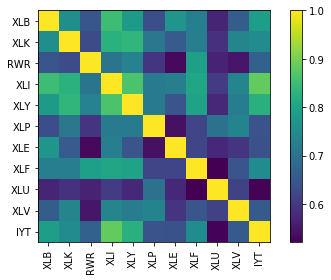

In [95]:
Plotting.plot_covariance(S);

In [96]:

# Calculate expected returns 
mu = expected_returns.mean_historical_return(opt_df)
#mu = expected_returns.capm_return(opt_df)

S = risk_models.CovarianceShrinkage(opt_df).ledoit_wolf()

# Optimize for maximum Sharpe ratio. The result is also referred to as the tangency portfolio, 
# as it is the portfolio for which the capital market line is tangent to the efficient frontier.

ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()

#If you want minimum volatility portfolio use: 
#raw_weights =ef.min_volatility()

#round weights
cleaned_weights = ef.clean_weights()

ef.save_weights_to_file("weights.csv")  

print(cleaned_weights)

ef.portfolio_performance(verbose=True)

{'XLB': 0.0, 'XLK': 0.25895, 'RWR': 0.0, 'XLI': 0.0, 'XLY': 0.0, 'XLP': 0.34463, 'XLE': 0.0, 'XLF': 0.0, 'XLU': 0.2185, 'XLV': 0.17792, 'IYT': 0.0}
Expected annual return: 11.0%
Annual volatility: 15.5%
Sharpe Ratio: 0.58


(0.10973282770813425, 0.1546997150579963, 0.5800452035383115)

In [97]:
#Now convert weights into shares to buy given total portfolio value, say $20,000

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(opt_df)
da = DiscreteAllocation(raw_weights, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
print(allocation)

Discrete allocation performed with $8.67 leftover
{'XLK': 58.0, 'XLP': 119.0, 'XLU': 78.0, 'XLV': 37.0}


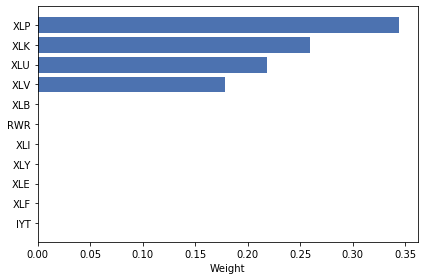

In [98]:
Plotting.plot_weights(cleaned_weights)

In [99]:
#MONTE CARLO SIMULATION OF OPTIMIZED PORTFOLIO

In [100]:
daily_returns = concat_df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT
date,,,,,,,,,,,
2003-10-13,0.010513,0.003068,0.005031,0.004144,0.010219,0.003806,0.004014,0.015786,0.006372,0.002849,0.015557
2003-10-14,0.006506,-0.002548,0.000697,0.004946,0.005394,0.005222,-0.003998,0.005919,0.002712,0.001423,0.005430
2003-10-15,-0.000860,0.006139,-0.003963,0.001643,-0.004024,-0.001416,-0.014456,-0.002574,-0.012621,-0.002128,-0.007908
2003-10-16,0.003448,0.003557,0.004534,0.000413,0.004378,0.001418,0.010594,0.001104,0.004563,0.005333,0.003110
2003-10-17,-0.009452,-0.016211,-0.007846,-0.006964,-0.014080,-0.006135,-0.006856,-0.008836,-0.006366,-0.011319,-0.004458


In [101]:
#Calculate the mean of daily returns for each sector

avg_daily_return_xlb = daily_returns.mean()['XLB']
avg_daily_return_xlk = daily_returns.mean()['XLK']
avg_daily_return_rwr = daily_returns.mean()['RWR']
avg_daily_return_xli = daily_returns.mean()['XLI']
avg_daily_return_xly = daily_returns.mean()['XLY']
avg_daily_return_xlp = daily_returns.mean()['XLP']
avg_daily_return_xle = daily_returns.mean()['XLE']
avg_daily_return_xlf = daily_returns.mean()['XLF']
avg_daily_return_xlu = daily_returns.mean()['XLU']
avg_daily_return_xlv = daily_returns.mean()['XLV']
avg_daily_return_iyt = daily_returns.mean()['IYT']


In [102]:
#Calculate the standard deviation of returns for each sector

std_dev_daily_return_xlb = daily_returns.std()['XLB']
std_dev_daily_return_xlk = daily_returns.std()['XLK']
std_dev_daily_return_rwr = daily_returns.std()['RWR']
std_dev_daily_return_xli = daily_returns.std()['XLI']
std_dev_daily_return_xly = daily_returns.std()['XLY']
std_dev_daily_return_xlp = daily_returns.std()['XLP']
std_dev_daily_return_xle = daily_returns.std()['XLE']
std_dev_daily_return_xlf = daily_returns.std()['XLF']
std_dev_daily_return_xlu = daily_returns.std()['XLU']
std_dev_daily_return_xlv = daily_returns.std()['XLV']
std_dev_daily_return_iyt = daily_returns.std()['IYT']

In [103]:

# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 30

# Set last closing prices

xlb_last_price = concat_df['XLB'][-1]
xlk_last_price = concat_df['XLK'][-1]
rwr_last_price = concat_df['RWR'][-1]
xli_last_price = concat_df['XLI'][-1]
xly_last_price = concat_df['XLY'][-1]
xlp_last_price = concat_df['XLP'][-1]
xle_last_price = concat_df['XLE'][-1]
xlf_last_price = concat_df['XLF'][-1]
xlu_last_price = concat_df['XLU'][-1]
xlv_last_price = concat_df['XLV'][-1]
iyt_last_price = concat_df['IYT'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next 30 days, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of the sector etfs
    simulated_xlb_prices = [xlb_last_price]
    simulated_xlk_prices = [xlk_last_price]
    simulated_rwr_prices = [rwr_last_price]
    simulated_xli_prices = [xli_last_price]  
    simulated_xly_prices = [xly_last_price]
    simulated_xlp_prices = [xlp_last_price]
    simulated_xle_prices = [xle_last_price]
    simulated_xlf_prices = [xlf_last_price]
    simulated_xlu_prices = [xlu_last_price]  
    simulated_xlv_prices = [xlv_last_price]
    simulated_iyt_prices = [iyt_last_price]
    
    
    # Simulate the returns for 30 days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_xlb_price = simulated_xlb_prices[-1] * (1 + np.random.normal(avg_daily_return_xlb, std_dev_daily_return_xlb))
        simulated_xlk_price = simulated_xlk_prices[-1] * (1 + np.random.normal(avg_daily_return_xlk, std_dev_daily_return_xlk))
        simulated_rwr_price = simulated_rwr_prices[-1] * (1 + np.random.normal(avg_daily_return_rwr, std_dev_daily_return_rwr))
        simulated_xli_price = simulated_xli_prices[-1] * (1 + np.random.normal(avg_daily_return_xli, std_dev_daily_return_xli))
        simulated_xly_price = simulated_xly_prices[-1] * (1 + np.random.normal(avg_daily_return_xly, std_dev_daily_return_xly))
        simulated_xlp_price = simulated_xlp_prices[-1] * (1 + np.random.normal(avg_daily_return_xlp, std_dev_daily_return_xlp))
        simulated_xle_price = simulated_xle_prices[-1] * (1 + np.random.normal(avg_daily_return_xle, std_dev_daily_return_xle))
        simulated_xlf_price = simulated_xlf_prices[-1] * (1 + np.random.normal(avg_daily_return_xlf, std_dev_daily_return_xlf))
        simulated_xlu_price = simulated_xlu_prices[-1] * (1 + np.random.normal(avg_daily_return_xlu, std_dev_daily_return_xlu))
        simulated_xlv_price = simulated_xlv_prices[-1] * (1 + np.random.normal(avg_daily_return_xlv, std_dev_daily_return_xlv))
        simulated_iyt_price = simulated_iyt_prices[-1] * (1 + np.random.normal(avg_daily_return_iyt, std_dev_daily_return_iyt))
        
        # Append the simulated price to the list
        simulated_xlb_prices.append(simulated_xlb_price)
        simulated_xlk_prices.append(simulated_xlk_price)
        simulated_rwr_prices.append(simulated_rwr_price)
        simulated_xli_prices.append(simulated_xli_price)
        simulated_xly_prices.append(simulated_xly_price)
        simulated_xlp_prices.append(simulated_xlp_price)
        simulated_xle_prices.append(simulated_xle_price)
        simulated_xlf_prices.append(simulated_xlf_price)
        simulated_xlu_prices.append(simulated_xlu_price)
        simulated_xlv_prices.append(simulated_xlv_price)
        simulated_iyt_prices.append(simulated_iyt_price)
        
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["XLB"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLK"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["RWR"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLI"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["XLY"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLP"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["XLE"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLF"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["XLU"] = pd.Series(simulated_xlb_prices)
    simulated_price_df["XLV"] = pd.Series(simulated_xlk_prices)
    simulated_price_df["IYT"] = pd.Series(simulated_xlb_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the optimized portfolio weights (XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT)
    weights = [0, 0.26569,0,0,0,.32729,0,0,.22731,.17971,0]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997371,1.007208,0.999256,1.005128,0.996906,1.003052,1.001197,0.997833,0.993541,1.014146,...,1.008979,0.999139,0.992993,0.995930,0.986203,0.983251,1.007121,0.994643,1.002108,1.004602
2,0.999359,1.015428,0.994154,0.987775,0.996775,1.010168,0.989694,1.013992,1.009277,1.014351,...,0.987190,0.988229,0.998447,1.012662,0.995492,0.975677,0.993550,0.996791,1.008761,1.017352
3,1.005050,1.033804,0.982837,0.983207,0.989360,1.004405,0.968040,1.028254,1.000802,1.009646,...,0.986071,0.981137,0.988384,1.027438,1.009451,0.962741,0.998632,0.986114,0.997313,1.029546
4,1.012518,1.032002,0.977897,0.984271,1.002728,1.011281,0.981914,1.025165,0.981577,1.014543,...,0.980441,0.984896,0.993550,1.037289,1.017931,0.966541,1.005879,0.992322,1.011435,1.029183


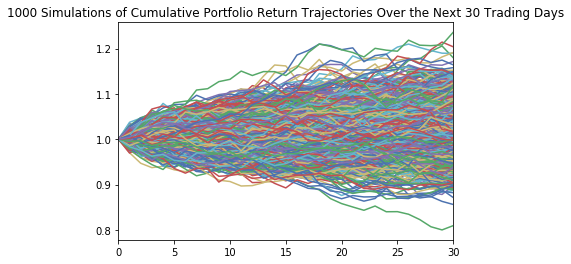

In [104]:
# Plot `1000` simulations of the potential trajectories of the portfolio based on 30 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [105]:
# Select the last row for prices (prices of each simulation on the 30th trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.988338
1    1.024278
2    1.046109
3    0.923430
4    1.140582
Name: 30, dtype: float64

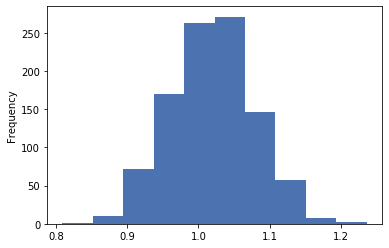

In [106]:
#Plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)


In [107]:
#Calculate probability distribution
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)


(1.023, 1.065]    0.271
(0.98, 1.023]     0.263
(0.937, 0.98]     0.170
(1.065, 1.108]    0.146
(0.895, 0.937]    0.072
(1.108, 1.151]    0.057
(0.852, 0.895]    0.010
(1.151, 1.194]    0.008
(1.194, 1.236]    0.002
(0.808, 0.852]    0.001
Name: 30, dtype: float64

In [108]:

# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.904655
0.975    1.136149
Name: 30, dtype: float64

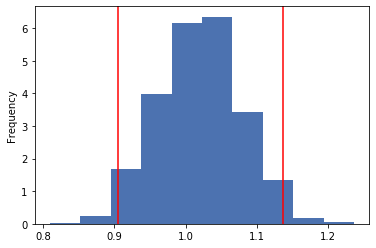

In [109]:
# Use the `plot` function to create a probability distribution histogram of simulated ending returns
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [110]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = (initial_investment * confidence_interval.iloc[0])
investment_pnl_upper_bound = (initial_investment * confidence_interval.iloc[1])
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 30 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 30 trading days will end within in the range of $9046.54971005408 and $11361.492247583716


In [111]:
#Add optimized portfolio returns to daily returns dataframe

daily_returns['optimized']= (daily_returns['XLK']*.258599)+(daily_returns['XLP']*.34463)
+(daily_returns['XLU']*.2185)+(daily_returns['XLV']*.17792)
daily_returns.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT,optimized
date,,,,,,,,,,,,
2003-10-13,0.010513,0.003068,0.005031,0.004144,0.010219,0.003806,0.004014,0.015786,0.006372,0.002849,0.015557,0.002105
2003-10-14,0.006506,-0.002548,0.000697,0.004946,0.005394,0.005222,-0.003998,0.005919,0.002712,0.001423,0.005430,0.001141
2003-10-15,-0.000860,0.006139,-0.003963,0.001643,-0.004024,-0.001416,-0.014456,-0.002574,-0.012621,-0.002128,-0.007908,0.001099
2003-10-16,0.003448,0.003557,0.004534,0.000413,0.004378,0.001418,0.010594,0.001104,0.004563,0.005333,0.003110,0.001408
2003-10-17,-0.009452,-0.016211,-0.007846,-0.006964,-0.014080,-0.006135,-0.006856,-0.008836,-0.006366,-0.011319,-0.004458,-0.006306


In [112]:
#Add equal weighted portfolio returns to daily returns dataframe

daily_returns['equal']= (daily_returns['XLB']*.090909)+(daily_returns['XLK']*.090909)
+(daily_returns['RWR']*.090909)+(daily_returns['XLI']*.090909)+(daily_returns['XLY']*.090909)+(daily_returns['XLP']*.090909)
+(daily_returns['XLE']*.090909)+(daily_returns['XLF']*.090909)+(daily_returns['XLU']*.090909)+(daily_returns['XLV']*.090909)
+(daily_returns['IYT']*.090909)



daily_returns.head()

,XLB,XLK,RWR,XLI,XLY,XLP,XLE,XLF,XLU,XLV,IYT,optimized,equal
date,,,,,,,,,,,,,
2003-10-13,0.010513,0.003068,0.005031,0.004144,0.010219,0.003806,0.004014,0.015786,0.006372,0.002849,0.015557,0.002105,0.001235
2003-10-14,0.006506,-0.002548,0.000697,0.004946,0.005394,0.005222,-0.003998,0.005919,0.002712,0.001423,0.005430,0.001141,0.000360
2003-10-15,-0.000860,0.006139,-0.003963,0.001643,-0.004024,-0.001416,-0.014456,-0.002574,-0.012621,-0.002128,-0.007908,0.001099,0.000480
2003-10-16,0.003448,0.003557,0.004534,0.000413,0.004378,0.001418,0.010594,0.001104,0.004563,0.005333,0.003110,0.001408,0.000637
2003-10-17,-0.009452,-0.016211,-0.007846,-0.006964,-0.014080,-0.006135,-0.006856,-0.008836,-0.006366,-0.011319,-0.004458,-0.006306,-0.002333


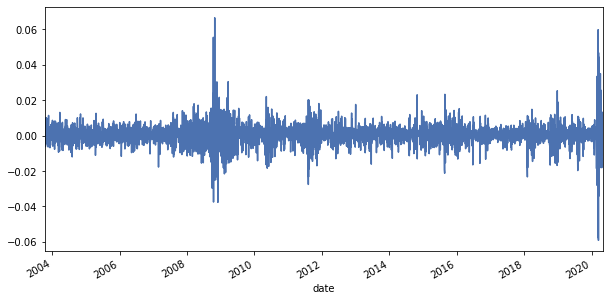

In [113]:
#plot daily returns of optimized portfolio

daily_returns['optimized'].plot(figsize=(10,5))

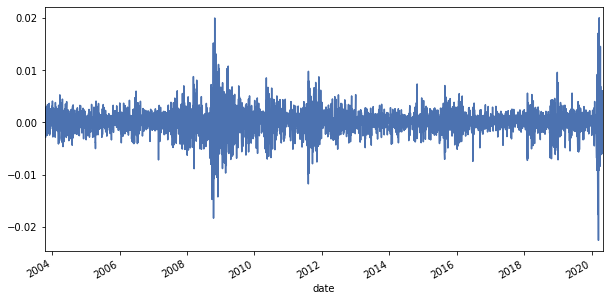

In [114]:
#plot daily returns of equally weighted portfolio

daily_returns['equal'].plot(figsize=(10,5))


In [115]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_optimized = (1 + daily_returns['optimized']).cumprod()
cumulative_returns_equal = (1 + daily_returns['equal']).cumprod()

cumulative_returns_optimized.head()

date
2003-10-13    1.002105
2003-10-14    1.003248
2003-10-15    1.004351
2003-10-16    1.005766
2003-10-17    0.999423
Name: optimized, dtype: float64

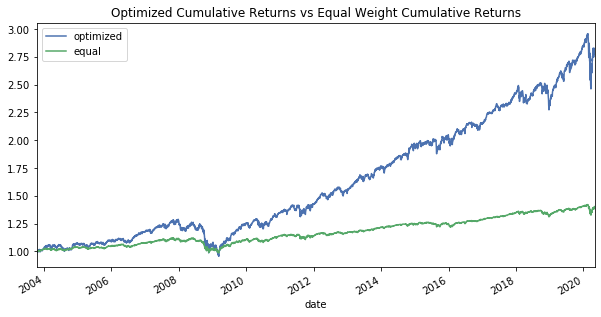

In [117]:
cumulative_returns_optimized.plot(figsize=(10,5),legend = True)
cumulative_returns_equal.plot(figsize=(10,5),legend = True, title ='Optimized Cumulative Returns vs Equal Weight Cumulative Returns')